# Model training

Note: Flow generation is notably quicker when utilizing instance masks instead of semantic masks. Therefore, it is recommended to convert semantic masks into instance masks prior to model training. To convert masks, see jupyter-notebook: step 1 data preperation.

In [1]:

import matplotlib.pyplot as plt
import torch
from swincell.utils.utils import load_default_config
from swincell.utils.data_utils import flow_reshaped, split_dataset
# import warnings
# warnings.filterwarnings('ignore')


/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure training parameters

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# data_dir = '../../colon_dataset/colon_16bit_demo/'
data_dir = '../../colon_dataset/colon_demo/'
args =load_default_config()
args.data_dir=data_dir
args.roi_x = 64
args.roi_y = 64
args.roi_z = 32
args.max_epochs = 20
args.downsample_factor = 1 # downsample the input image if resolution is too high





In [3]:


train_datalist, val_datalist = split_dataset(data_dir, split_ratios=[0.8,0.2])
print(len(train_datalist),len(val_datalist))




4 1


In [4]:
from swincell.utils.data_utils import folder_loader
train_loader,val_loader = folder_loader(args)

folder loader for tiff images
length of train/valid 4 4 1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


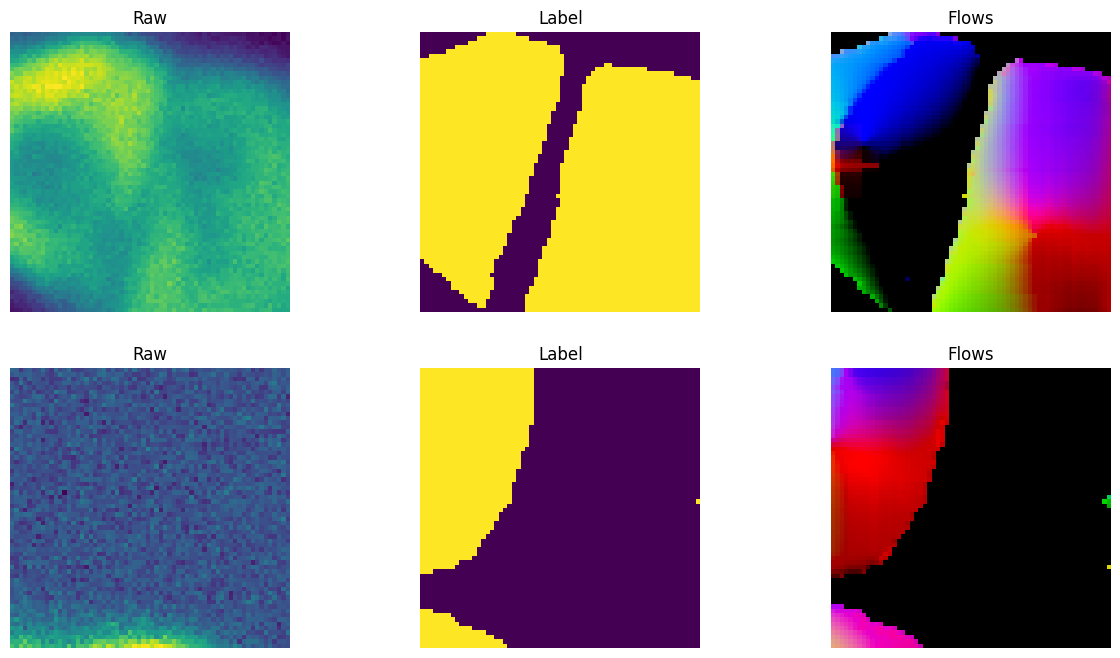

In [6]:


n_row = 2
fig, axes = plt.subplots(n_row, 3,sharex=False, sharey=False, figsize=(15,8))

slice2view = int(args.roi_z//2)
for i in range(n_row):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    # print(img2plot.shape, label2plot.shape)
    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()

    mask0= label2plot[0,0,:,:,slice2view].detach().cpu()
    # one flow
    flow= label2plot[0,1:4,:,:,slice2view].detach().cpu().numpy().transpose(1, 2, 0)

    # print(mask0.max(),mask0.min())
    # print('mask2',mask2.max(),mask2.min())
    axes[i,0].imshow(img2plot[0,0,:,:,slice2view])
    axes[i,0].set_title('Raw')
    
    axes[i,1].imshow(mask0)
    axes[i,1].set_title('Label')
    axes[i,2].imshow(flow)
    axes[i,2].set_title('Flows')

    for col in range(3):
      axes[i,col].axis('off')



In [7]:
from monai.networks.nets import SwinUNETR
from swincell.utils.utils import AverageMeter
model = SwinUNETR(
            img_size=(args.roi_x, args.roi_y, args.roi_z),
            in_channels=1,
            out_channels=4,
            # feature_size=args.feature_size,
            feature_size=48,
            use_checkpoint=None,
        ).to(device)

from torch.nn import MSELoss,BCEWithLogitsLoss
from monai.losses import DiceLoss
loss1 = MSELoss(reduction='mean')
loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
losses = [loss1,loss2]

optimizer = torch.optim.Adam(model.parameters(), lr=args.optim_lr, weight_decay=1e-5)

# Model training

In [8]:
from swincell.trainer import train_epoch
import time

train_losses = []
for epoch in range(args.max_epochs):
    epoch_time = time.time()
    train_loss, train_img_list = train_epoch(
            model, train_loader, optimizer, epoch=epoch, loss_func=losses, args=args
        )
    print(
                "Final training  {}/{}".format(epoch, args.max_epochs - 1),
                "loss: {:.4f}".format(train_loss),
                "time {:.2f}s".format(time.time() - epoch_time),
            )
    train_losses.append(train_loss)



Epoch 0/20 0/4 loss: 2.5086 time 15.47s
Epoch 0/20 1/4 loss: 2.7770 time 0.13s
Epoch 0/20 2/4 loss: 2.8091 time 0.12s
Epoch 0/20 3/4 loss: 2.6866 time 0.12s
Final training  0/19 loss: 2.6866 time 15.91s
Epoch 1/20 0/4 loss: 2.6034 time 15.64s
Epoch 1/20 1/4 loss: 2.4577 time 0.12s
Epoch 1/20 2/4 loss: 2.3991 time 0.12s
Epoch 1/20 3/4 loss: 2.4305 time 0.12s
Final training  1/19 loss: 2.4305 time 16.11s
Epoch 2/20 0/4 loss: 2.5997 time 14.35s
Epoch 2/20 1/4 loss: 2.5372 time 0.12s
Epoch 2/20 2/4 loss: 2.7149 time 0.31s
Epoch 2/20 3/4 loss: 2.6517 time 0.12s
Final training  2/19 loss: 2.6517 time 15.01s
Epoch 3/20 0/4 loss: 2.0264 time 14.83s
Epoch 3/20 1/4 loss: 2.1197 time 0.12s
Epoch 3/20 2/4 loss: 2.1523 time 0.12s
Epoch 3/20 3/4 loss: 2.0977 time 0.12s
Final training  3/19 loss: 2.0977 time 15.29s
Epoch 4/20 0/4 loss: 2.3630 time 14.57s
Epoch 4/20 1/4 loss: 2.3557 time 0.12s
Epoch 4/20 2/4 loss: 2.2619 time 0.12s
Epoch 4/20 3/4 loss: 2.2334 time 0.12s
Final training  4/19 loss: 2.23

Text(0, 0.5, 'loss')

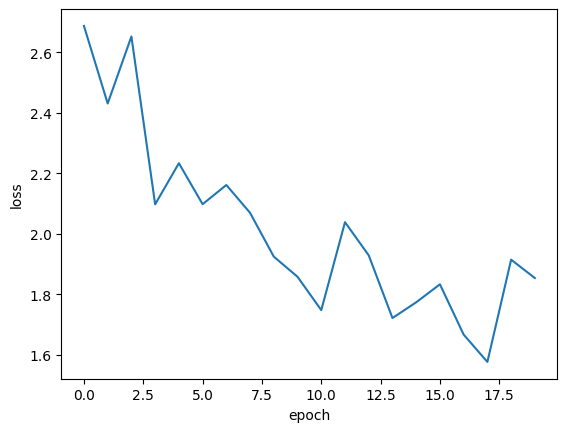

In [9]:
#plot loss
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')


In [24]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles

model_path = './path_to_model'   #load trained model in previous steps
model = SwinUNETR(
    img_size=args.ROI,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    # roi_size=(96,96,96),
    roi_size=(128,128,32),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.6)


FileNotFoundError: [Errno 2] No such file or directory: 'model_final.pt'

# Model inference

In [ ]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(val_loader):
            data_raw, target = batch_data["image"], batch_data["label"]
            data_raw, target = data_raw.cuda(0), target.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_raw)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())
            val_labels_list = target
            val_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(val_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            val_output_convert1 = post_pred(post_sigmoid(val_outputs_list))
            val_output_convert2 = post_trans(logits)
            print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

In [86]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()